First Model
- In this notebook, we first label the data so that our model has a target to predict on (asleep or awake).
-  

# Imports, Load data

In [7]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# load in score function
from metric import score

# format display 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# global random state
random_state = 0

In [9]:
# read in the data
root = 'data/'
train = pd.read_parquet(root + 'train_series.parquet')
events = pd.read_csv(root + 'train_events.csv')

# Label Data
- Awake
- Asleep
- Unknown (Device not worn)

In [23]:
# get a single user
example_user = '038441c925bb'
train_example = train.loc[train['series_id'] == example_user, :].copy()

# convert to datetime
train_example['timestamp'] = pd.to_datetime(train_example['timestamp'], utc=False)

In [24]:
# merge example with events table
df = train_example.merge(events, how='left', on=['series_id', 'step']).drop(['timestamp_y', 'night'], axis=1)

# rename timestamp_x column to timestamp
df.rename(columns={'timestamp_x': 'timestamp'}, inplace=True)

# check
df.shape

(389880, 6)

389k rows for our user.

In [25]:
# this cell drops the dates where no onset or wakeup occurred

# # get valid dates (days with events recorded)
# valid_dates = train_final[train_final['event'].notna()].date.unique()

# # drop rows that aren't in valid_dates
# train_final = train_final[train_final['date'].isin(valid_dates)]

# # check
# train_final.shape

In [26]:
# look at the rows where events occurred
df[df['event'].notna()].head()

,series_id,step,timestamp,anglez,enmo,event
4992,038441c925bb,4992,2018-08-14 22:26:00-04:00,-78.691,0.010,onset
10932,038441c925bb,10932,2018-08-15 06:41:00-04:00,-61.578,0.026,wakeup
20244,038441c925bb,20244,2018-08-15 19:37:00-04:00,-6.387,0.018,onset
27492,038441c925bb,27492,2018-08-16 05:41:00-04:00,-45.355,0.016,wakeup
39996,038441c925bb,39996,2018-08-16 23:03:00-04:00,-1.787,0.000,onset


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389880 entries, 0 to 389879
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype                    
---  ------     --------------   -----                    
 0   series_id  389880 non-null  object                   
 1   step       389880 non-null  uint32                   
 2   timestamp  389880 non-null  datetime64[ns, UTC-04:00]
 3   anglez     389880 non-null  float32                  
 4   enmo       389880 non-null  float32                  
 5   event      38 non-null      object                   
dtypes: datetime64[ns, UTC-04:00](1), float32(2), object(2), uint32(1)
memory usage: 13.4+ MB


The majority of 'event' rows are null, as no event occurred at those. To address this, we forward fill the event column:

In [28]:
# forward fill the event column where sleep time is classified as 'onset' and awake time is classified as 'wakeup'
df['event'].ffill(inplace=True)

# fill the null rows at beginning with 'wakeup'
df.fillna('wakeup', inplace=True)

# check that all nulls are filled
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389880 entries, 0 to 389879
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype                    
---  ------     --------------   -----                    
 0   series_id  389880 non-null  object                   
 1   step       389880 non-null  uint32                   
 2   timestamp  389880 non-null  datetime64[ns, UTC-04:00]
 3   anglez     389880 non-null  float32                  
 4   enmo       389880 non-null  float32                  
 5   event      389880 non-null  object                   
dtypes: datetime64[ns, UTC-04:00](1), float32(2), object(2), uint32(1)
memory usage: 13.4+ MB


Now, we'll check a few of the step indices where events occurred to ensure the forward fill worked correctly:

In [29]:
# check 1
df.set_index('step').loc[4990:4994]

,series_id,timestamp,anglez,enmo,event
step,,,,,
4990,038441c925bb,2018-08-14 22:25:50-04:00,-78.710,0.010,wakeup
4991,038441c925bb,2018-08-14 22:25:55-04:00,-78.730,0.010,wakeup
4992,038441c925bb,2018-08-14 22:26:00-04:00,-78.691,0.010,onset
4993,038441c925bb,2018-08-14 22:26:05-04:00,-78.665,0.010,onset
4994,038441c925bb,2018-08-14 22:26:10-04:00,-78.466,0.010,onset


In [30]:
# check 2
df.set_index('step').loc[10930:10934]

,series_id,timestamp,anglez,enmo,event
step,,,,,
10930,038441c925bb,2018-08-15 06:40:50-04:00,-58.177,0.036,onset
10931,038441c925bb,2018-08-15 06:40:55-04:00,-61.438,0.027,onset
10932,038441c925bb,2018-08-15 06:41:00-04:00,-61.578,0.026,wakeup
10933,038441c925bb,2018-08-15 06:41:05-04:00,-61.744,0.026,wakeup
10934,038441c925bb,2018-08-15 06:41:10-04:00,-61.786,0.027,wakeup


Now, we need to map these values to a sleep col to use as our final label:

In [31]:
# create asleep (label) col
df['asleep'] = df['event'].apply(lambda x: 1 if x == 'onset' else 0)

The value count for awake times should be roughly double that of sleep time (16 hours awake, 8 hours asleep):

In [32]:
df['asleep'].value_counts()

asleep
0    269796
1    120084
Name: count, dtype: int64

- Slightly greater than the expected 2:1 ratio. This is because __inactive periods are labeled as 'awake'__.
- This will definitely effect our model's performance, but as of now, no better labeling method is known of.

In [33]:
# drop event col
df.drop('event', axis=1, inplace=True)

# final training dataframe (for the first user)
df.head()

,series_id,step,timestamp,anglez,enmo,asleep
0,038441c925bb,0,2018-08-14 15:30:00-04:00,2.637,0.022,0
1,038441c925bb,1,2018-08-14 15:30:05-04:00,2.637,0.022,0
2,038441c925bb,2,2018-08-14 15:30:10-04:00,2.637,0.022,0
3,038441c925bb,3,2018-08-14 15:30:15-04:00,2.637,0.021,0
4,038441c925bb,4,2018-08-14 15:30:20-04:00,2.637,0.022,0


Currently, the only features are the raw anglez and enmo columns. "asleep" is our label.

In [22]:
# export
df.to_csv('data/single_user_1.csv', index=False)

# Feature creation

In [3]:
# anglez
df['anglez_diff'] = df['anglez'].diff()
df['anglez_diff'] = df['anglez_diff'].fillna(0)

df['anglez_rolling_mean'] = df['anglez'].rolling(window=61, min_periods=1).mean()
df['anglez_rolling_std'] = df['anglez'].rolling(window=61, min_periods=1).std()
df['anglez_rolling_std'] = df['anglez_diff'].fillna(0)



# enmo
df['enmo_diff'] = df['enmo'].diff()
df['enmo_diff'] = df['enmo_diff'].fillna(0)

df['enmo_rolling_mean'] = df['enmo'].rolling(window=61, min_periods=1).mean()
df['enmo_rolling_std'] = df['enmo'].rolling(window=61, min_periods=1).std()
df['enmo_rolling_std'] = df['anglez_diff'].fillna(0)

In [4]:
# check
df.head()

,series_id,step,anglez,enmo,date,asleep,anglez_diff,anglez_rolling_mean,anglez_rolling_std,enmo_diff,enmo_rolling_mean,enmo_rolling_std
0,038441c925bb,3240,67.175,0.015,2018-08-15,0,0.000,67.175,0.000,0.000,0.015,0.000
1,038441c925bb,3241,68.881,0.021,2018-08-15,0,1.706,68.028,1.706,0.006,0.018,1.706
2,038441c925bb,3242,73.114,0.034,2018-08-15,0,4.233,69.723,4.233,0.013,0.024,4.233
3,038441c925bb,3243,73.692,0.030,2018-08-15,0,0.578,70.715,0.578,-0.004,0.025,0.578
4,038441c925bb,3244,72.685,0.020,2018-08-15,0,-1.007,71.109,-1.007,-0.011,0.024,-1.007


x features added in total

# Model 1

In [5]:
# create features and target
X = df.drop(['series_id', 'asleep', 'step', 'date'], axis=1)
y = df['asleep']

In [6]:
# create pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('logreg', LogisticRegression(n_jobs=-1, random_state=random_state))])

In [7]:
# cross validate
scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

# print results
scores, scores.mean()

(array([0.78894067, 0.83249574, 0.7408778 , 0.78022965, 0.78140229]),
 0.7847892300194931)

In [8]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# fit pipeline
pipe.fit(X_train, y_train)

# get preds
preds = pipe.predict(X_test)


print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83     41789
           1       0.70      0.74      0.72     23875

    accuracy                           0.79     65664
   macro avg       0.77      0.78      0.78     65664
weighted avg       0.79      0.79      0.79     65664



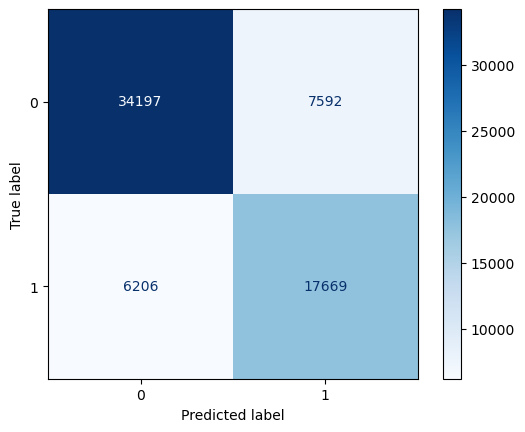

In [9]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Blues');

In [10]:
# add preds col
df_copy = df.copy()
df_copy['pred'] = pipe.predict(X)

# check
df_copy.head()

,series_id,step,anglez,enmo,date,asleep,anglez_diff,anglez_rolling_mean,anglez_rolling_std,enmo_diff,enmo_rolling_mean,enmo_rolling_std,pred
0,038441c925bb,3240,67.175,0.015,2018-08-15,0,0.000,67.175,0.000,0.000,0.015,0.000,0
1,038441c925bb,3241,68.881,0.021,2018-08-15,0,1.706,68.028,1.706,0.006,0.018,1.706,0
2,038441c925bb,3242,73.114,0.034,2018-08-15,0,4.233,69.723,4.233,0.013,0.024,4.233,0
3,038441c925bb,3243,73.692,0.030,2018-08-15,0,0.578,70.715,0.578,-0.004,0.025,0.578,0
4,038441c925bb,3244,72.685,0.020,2018-08-15,0,-1.007,71.109,-1.007,-0.011,0.024,-1.007,0


In [11]:
# rows where prediction switches from 0 to 1 or 1 to 0
df_copy["pred_switch"] = (df_copy["pred"].diff() != 0).astype(int)

In [12]:
# look at the value counts
df_copy["pred_switch"].value_counts()

pred_switch
0    326251
1      2069
Name: count, dtype: int64

- For this user, we have 19 valid nights of data, meaning a perfect model would have 38 rows where sleep state switched.
- Currently, our model has over 2000. This is because at any given 5-second timestep, our model is predicting whether the user is asleep or awake at that given moment. This would include times in the night where the user briefly woke up.
- We want to identify the sleep window, and return the step where it began and where it ended on each day.

In [130]:
# group by the date to take the first occurence of predicted onset
predicted_onset = df_copy.query("pred_switch == 1 & pred == 1").groupby("date")['step'].min()

# idk
predicted_wakeup = df_copy.query("pred_switch == 1 & pred == 0").groupby("date")['step'].min()